In [40]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'
from tqdm import tqdm

In [2]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())

# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 12
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'

In [10]:
import os
# Set enviornment variable TORCH_HOME to specify where to download pretrained models
os.environ['TORCH_HOME'] = os.path.expanduser('~/TORCH_HOME')

In [46]:
import torchvision.transforms as transforms
import torch

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [32]:
# Download CIFAIR10 dataset in ~/TORCH_HOME/datasets/CIFAR10
from torchvision.datasets import CIFAR10

ds_cifar = CIFAR10(root=os.path.expanduser('~/TORCH_HOME/datasets'), 
                   transform=transform,
                   download=True)

Files already downloaded and verified


In [33]:
ds_cifar

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /home/nipun.batra/TORCH_HOME/datasets
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [34]:
# Split dataset into train, pool and test
# train: 10 images per class
# test: 100 images per class
# pool: remaining images

from torch.utils.data import Subset
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Get indices of all images in the dataset
indices = np.arange(len(ds_cifar))

# Shuffle indices
np.random.shuffle(indices)

# Split indices into train, pool and test

# 10 images per class in train
train_indices = []
for i in range(10):
    train_indices.extend(indices[np.array(ds_cifar.targets) == i][:10])

# 100 images per class in test
test_indices = []
for i in range(10):
    test_indices.extend(indices[np.array(ds_cifar.targets) == i][10:110])

# Remaining images in pool
pool_indices = np.setdiff1d(indices, np.concatenate([train_indices, test_indices]))


In [35]:
indices.shape

(50000,)

In [36]:
indices[np.array(ds_cifar.targets) == 0][:10]

array([33109, 36480, 21123, 17523,  2530, 27578, 46915,  9801,  9405,
        7905])

In [37]:
# Print number of images in each set
print(f'Number of images in train: {len(train_indices)}')
print(f'Number of images in test: {len(test_indices)}')
print(f'Number of images in pool: {len(pool_indices)}')

Number of images in train: 100
Number of images in test: 1000
Number of images in pool: 48900


In [38]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [43]:
# image size
ds_cifar[0][0].shape

torch.Size([3, 32, 32])

In [64]:
# Simple CNN model 
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import torch.nn as nn
import torch.nn.functional as F

class Featurizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 input channels, 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2) # 2x2 max pooling
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 input channels, 16 output channels, 5x5 kernel

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # conv1 -> relu -> pool
        x = self.pool(F.relu(self.conv2(x))) # conv2 -> relu -> pool
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        return x

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 16 * 5 * 5 input features, 120 output features
        self.fc2 = nn.Linear(120, 84) # 120 input features, 84 output features
        self.fc3 = nn.Linear(84, 10) # 84 input features, 10 output features

    def forward(self, x):
        x = F.relu(self.fc1(x)) # fc1 -> relu
        x = F.relu(self.fc2(x)) # fc2 -> relu
        x = self.fc3(x) # fc3
        return x

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.featurizer = Featurizer()
        self.classifier = Classifier()

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

net = Net()

In [65]:
net(torch.randn(1, 3, 32, 32)).shape

torch.Size([1, 10])

In [68]:
net.featurizer(torch.randn(1, 3, 32, 32)).shape

torch.Size([1, 400])

In [69]:
net.featurizer(torch.randn(2, 3, 32, 32)).shape

torch.Size([2, 400])

In [72]:
ds_cifar[train_indices]

TypeError: list indices must be integers or slices, not list

In [71]:
net.featurizer(ds_cifar[train_indices]).shape

TypeError: list indices must be integers or slices, not list

In [73]:
# Plot the embeddings of some train images using t-SNE over the features of the featurizer

from sklearn.manifold import TSNE

# Get features of all train images
with torch.no_grad():
    train_features = []
    for i in tqdm(range(len(train_indices))):
        train_features.append(net.featurizer(ds_cifar[train_indices[i]][0].unsqueeze(0)).detach().numpy())
    train_features = np.concatenate(train_features, axis=0)

# Get labels of all train images
train_labels = np.array(ds_cifar.targets)[train_indices]



100%|██████████| 100/100 [00:08<00:00, 11.84it/s]


In [74]:
pd.DataFrame(train_features)

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,0.043069,0.040020,0.039191,0.040317,0.038809,0.061726,0.051463,0.056516,0.063033,0.054073,...,0.159013,0.104357,0.144799,0.156466,0.022028,0.171914,0.000000,0.004060,0.024480,0.014433
1,0.052658,0.050776,0.060158,0.080248,0.091635,0.081519,0.082246,0.040410,0.093928,0.085770,...,0.027028,0.026178,0.026923,0.053561,0.046029,0.000000,0.026367,0.021920,0.047104,0.022439
2,0.145973,0.143014,0.111015,0.113687,0.114175,0.121850,0.114685,0.151418,0.105819,0.140187,...,0.055407,0.000000,0.046569,0.116678,0.149058,0.023719,0.064234,0.172848,0.038562,0.150153
3,0.070926,0.045203,0.093500,0.055699,0.063200,0.113949,0.106912,0.048646,0.066010,0.072146,...,0.006381,0.061717,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.228452,0.168169,0.143679,0.243058,0.148381,0.148269,0.128912,0.023275,0.224148,0.250761,...,0.028063,0.000000,0.000000,0.000000,0.000000,0.009647,0.000000,0.000000,0.000000,0.015983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.330111,0.259713,0.300614,0.338429,0.218644,0.195021,0.253832,0.253520,0.313827,0.376419,...,0.078716,0.062131,0.064597,0.097439,0.112501,0.109309,0.111277,0.072206,0.044436,0.104123
96,0.262827,0.220885,0.197643,0.382890,0.257701,0.247012,0.264467,0.272442,0.225058,0.187384,...,0.139850,0.000000,0.146395,0.095709,0.103658,0.183453,0.272508,0.165032,0.025133,0.027145
97,0.157728,0.237232,0.149280,0.134930,0.144775,0.000000,0.093993,0.233828,0.222955,0.224181,...,0.180318,0.245167,0.346213,0.175338,0.169619,0.237813,0.065911,0.144279,0.000000,0.163262
98,0.270986,0.246109,0.311368,0.289007,0.148905,0.327890,0.211728,0.094774,0.196271,0.275515,...,0.070007,0.191295,0.196693,0.066211,0.000000,0.000000,0.119499,0.147440,0.152418,0.111899


/home/nipun.batra/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/nipun.batra/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 't-SNE of train features')

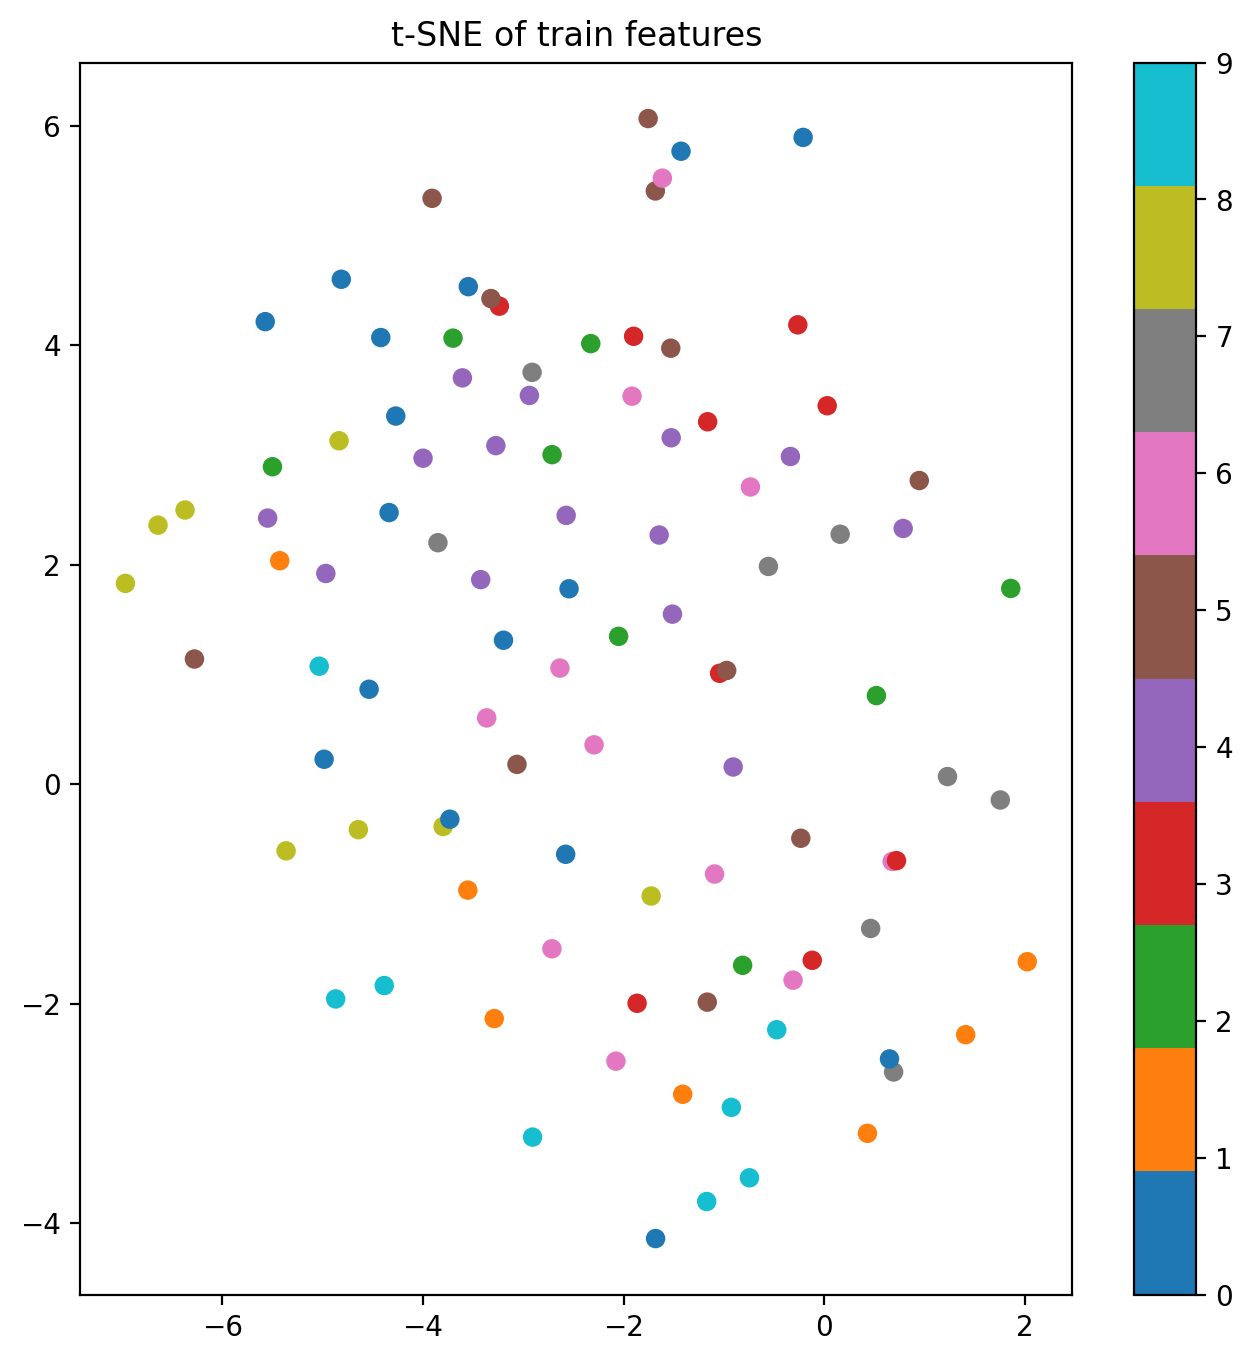

In [76]:

# Reduce dimensionality of features using t-SNE
train_features_tsne = TSNE(n_components=2).fit_transform(train_features)

# Plot features
plt.figure(figsize=(8, 8))
plt.scatter(train_features_tsne[:, 0], train_features_tsne[:, 1], c=train_labels, cmap='tab10')
plt.colorbar()
plt.title('t-SNE of train features')

In [77]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


In [78]:
batch_size = 32
losses = []
for epoch in range(15):
    for i in tqdm(range(0, len(train_indices), batch_size)):
        # get the inputs; data is a list of [inputs, labels]
        inputs = torch.stack([ds_cifar[idx][0] for idx in train_indices[i:i+batch_size]])
        labels = torch.tensor([ds_cifar[idx][1] for idx in train_indices[i:i+batch_size]])

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()   
    print(f"{epoch} {i} {loss:0.2f}")
    losses.append(loss.item())

100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


0 96 2.33


100%|██████████| 4/4 [00:02<00:00,  1.68it/s]


1 96 2.22


100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


2 96 2.07


100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


3 96 1.83


100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


4 96 1.48


 50%|█████     | 2/4 [00:01<00:01,  1.58it/s]

In [63]:
### CoreSet based Active Learning
### Extract features from the last layer of the CNN

net.eval()
with torch.no_grad():
    features = net(torch.stack([ds_cifar[idx][0] for idx in range(len(ds_cifar))])).numpy()

features.shape

(50000, 10)